In [1]:
import networkx as nx

import numpy as np
import pandas as pd

import random
import math

from sklearn import metrics

In [2]:
# hyperparameters

seed = random.randint(1, 1000)         # random seed

# Experiments on real data
Here we use 'Email network' from 'Stacking models for nearly optimal link prediction in complex networks' paper by Amir Ghasemian et al:
 - https://github.com/Aghasemian/OptimalLinkPrediction
 - https://www.pnas.org/content/117/38/23393 

## Step 1
### Graph and features imoprting, train-test splitting

We import the desired network and its features from `OLP` class and split the data into train and test sets.

In [3]:
N_EPOCH=5
ATTRS = False

In [4]:
import sys
sys.path.append("..")

from lib.generators.AttributedNetwork import AttributedNetwork


generator = AttributedNetwork(
    '../data/',
    'citeseer',
    features_to_normalize=['RAI', 'JC', 'AAI', 'PA'],
    with_attributes=ATTRS,
    seed=seed,
    vebrose=True
)

feature_names = generator.t_feature_names

INFO: Verbose output.
INFO: Reading data ...
INFO: Success!
INFO: Train/test splitting the data...
INFO: Success!
INFO: Calculating topological features: ['RAI', 'JC', 'AAI', 'PA']
INFO: Done calculating topological features
INFO: Calculating topological features: ['RAI', 'JC', 'AAI', 'PA']
INFO: Done calculating topological features
INFO: Calculating topological features: ['RAI', 'JC', 'AAI', 'PA']
INFO: Done calculating topological features


In [5]:
link_prediction_train, link_prediction_test, classifier_test = generator.TRAIN1_DF, generator.TEST1_DF, generator.TEST2_DF

link_prediction_train.dropna(inplace=True)
link_prediction_test.dropna(inplace=True)
classifier_test.dropna(inplace=True)

In [6]:
link_prediction_train.head()

,node1,node2,goal,RAI,JC,AAI,PA
0,1792,3841,0.0,0.0,0.0,0.0,0.000300
1,463,2695,0.0,0.0,0.0,0.0,0.001502
2,2807,3268,0.0,0.0,0.0,0.0,0.000000
3,409,3291,0.0,0.0,0.0,0.0,0.000901
4,2124,2878,0.0,0.0,0.0,0.0,0.000901


## Step 2
### Link prediction model

In [7]:
# set keras backend
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

# import the model function
from lib.Keras.model import model

EMBED_DIM = 32

Using plaidml.keras.backend backend.


In [8]:
attr_dim = len(link_prediction_train.head(1)['node_1_attrs'].values[0]) if ATTRS else 1

link_prediction_model = model(feature_names, attr_dim, embed_dim=EMBED_DIM, attrs=ATTRS)
link_prediction_model.summary()

INFO:plaidml:Opening device "metal_amd_radeon_pro_5300m.0"
INFO: Opening device "metal_amd_radeon_pro_5300m.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Topological features input ( (None, 4)                 0         
_________________________________________________________________
Hidden layer (Dense)         (None, 4)                 20        
_________________________________________________________________
output (Dense)               (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


DEBUG: Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.


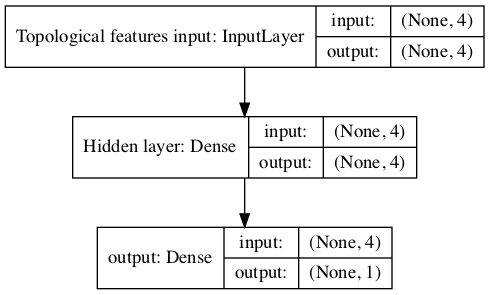

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(link_prediction_model, show_shapes=True)

In [10]:
from lib.data.data_arrange import data_arrange

x, y = data_arrange(link_prediction_train, feature_names, attrs=ATTRS)
link_prediction_model.fit(x, y, epochs=N_EPOCH) 

Epoch 1/5
7552/7552 [==============================] - 1s 158us/step - loss: 0.8463 - acc: 0.5727
Epoch 2/5
7552/7552 [==============================] - 1s 143us/step - loss: 0.8422 - acc: 0.5690
Epoch 3/5
7552/7552 [==============================] - 1s 144us/step - loss: 0.8358 - acc: 0.6905
Epoch 4/5
7552/7552 [==============================] - 1s 117us/step - loss: 0.8290 - acc: 0.6842
Epoch 5/5
7552/7552 [==============================] - 1s 98us/step - loss: 0.8227 - acc: 0.6806


DEBUG: matplotlib data path: /Users/andrejantonov/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data
DEBUG: CONFIGDIR=/Users/andrejantonov/.matplotlib
DEBUG: matplotlib version 3.4.1
DEBUG: interactive is False
DEBUG: platform is darwin
DEBUG: loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_frozen_importlib_external', '_io', 'marshal', 'posix', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', 'importlib.abc', '_operator', 'operator', 'keyword', '_heapq', 'heapq', 'itertools', 'reprlib', '_collections', 'collections', '_functools', 'functools', 'contextlib', 'importlib.util', 'g

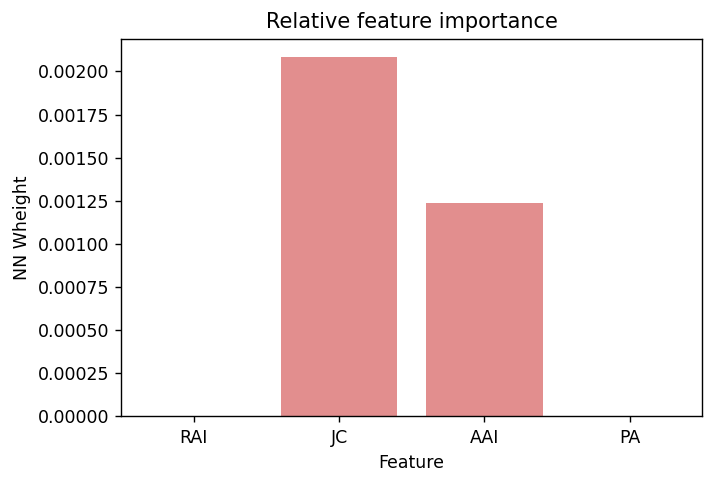

In [11]:
from lib.plotting.feature_importance import feature_importance

feature_importance(link_prediction_model, feature_names, embed_dim=EMBED_DIM, attrs=False)

In [12]:
# predicting the links

x, _ = data_arrange(link_prediction_test, feature_names, train=False, attrs=ATTRS)

prob = link_prediction_model.predict(x).squeeze()
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_test.join(prob)
link_proba.head(5)

,node1,node2,goal,RAI,JC,AAI,PA,prob
0,1486,3662,0.0,0.0,0.0,0.0,0.000265,0.459108
1,2000,2727,0.0,0.0,0.0,0.0,0.000265,0.459108
2,324,3999,0.0,0.0,0.0,0.0,0.000795,0.459766
3,1813,2958,0.0,0.0,0.0,0.0,0.000000,0.458779
4,1033,2119,0.0,0.0,0.0,0.0,0.001855,0.461082


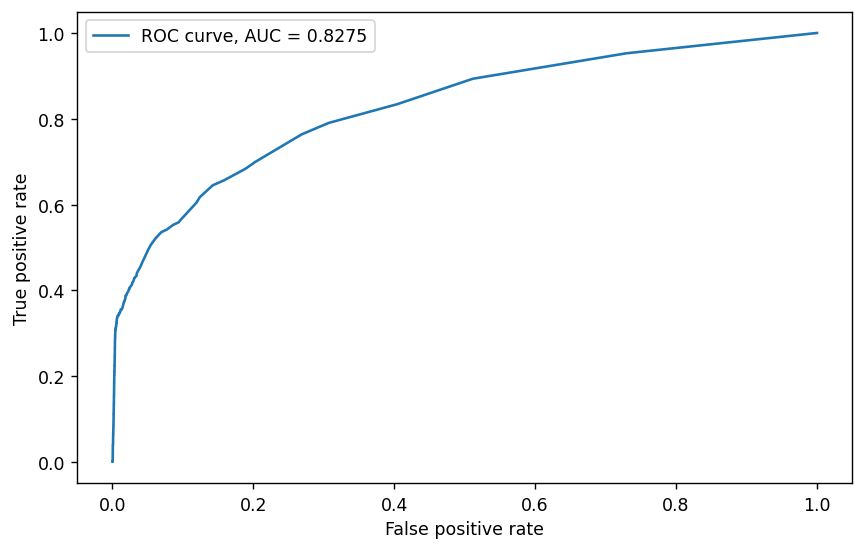

In [13]:
from lib.plotting.auc import plot_auc

# ROC-AUC for the link prediction model
plot_auc(link_proba, x='goal', y='prob')

## Step 3
Classifing error of prediction into "predictible" and "non-predictable" classes using median error

In [14]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba.head()

,node1,node2,goal,RAI,JC,AAI,PA,prob,abs_error
0,1486,3662,0.0,0.0,0.0,0.0,0.000265,0.459108,0.459108
1,2000,2727,0.0,0.0,0.0,0.0,0.000265,0.459108,0.459108
2,324,3999,0.0,0.0,0.0,0.0,0.000795,0.459766,0.459766
3,1813,2958,0.0,0.0,0.0,0.0,0.000000,0.458779,0.458779
4,1033,2119,0.0,0.0,0.0,0.0,0.001855,0.461082,0.461082


In [15]:
train_median_error = link_proba['abs_error'].median()
train_median_error

0.4594370722770691

In [16]:
link_proba['quality_label'] = link_proba.apply(lambda row: 1 if row['abs_error'] <= train_median_error else 0, axis=1)
link_proba.head()

,node1,node2,goal,RAI,JC,AAI,PA,prob,abs_error,quality_label
0,1486,3662,0.0,0.0,0.0,0.0,0.000265,0.459108,0.459108,1
1,2000,2727,0.0,0.0,0.0,0.0,0.000265,0.459108,0.459108,1
2,324,3999,0.0,0.0,0.0,0.0,0.000795,0.459766,0.459766,0
3,1813,2958,0.0,0.0,0.0,0.0,0.000000,0.458779,0.458779,1
4,1033,2119,0.0,0.0,0.0,0.0,0.001855,0.461082,0.461082,0


In [17]:
classification_model = model(feature_names, attr_dim, attrs=ATTRS)
classification_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Topological features input ( (None, 4)                 0         
_________________________________________________________________
Hidden layer (Dense)         (None, 4)                 20        
_________________________________________________________________
output (Dense)               (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


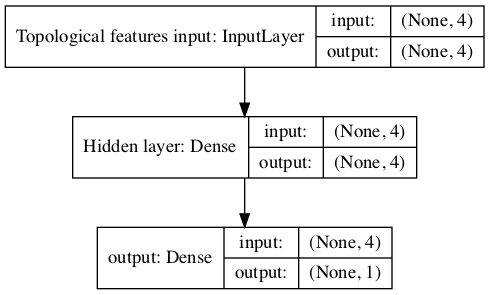

In [18]:
plot_model(classification_model, show_shapes=True)

In [19]:
x, y = data_arrange(link_proba, feature_names, goal='quality_label', attrs=ATTRS)
classification_model.fit(x, y, epochs=N_EPOCH) 

Epoch 1/5
1341650/1341650 [==============================] - 154s 115us/step - loss: 0.8601 - acc: 0.7147
Epoch 2/5
1341650/1341650 [==============================] - 185s 138us/step - loss: 0.7161 - acc: 0.9742
Epoch 3/5
1341650/1341650 [==============================] - 214s 159us/step - loss: 0.6464 - acc: 0.9997
Epoch 4/5
1341650/1341650 [==============================] - 308s 230us/step - loss: 0.6229 - acc: 0.9997
Epoch 5/5
1341650/1341650 [==============================] - 395s 294us/step - loss: 0.6105 - acc: 0.9997


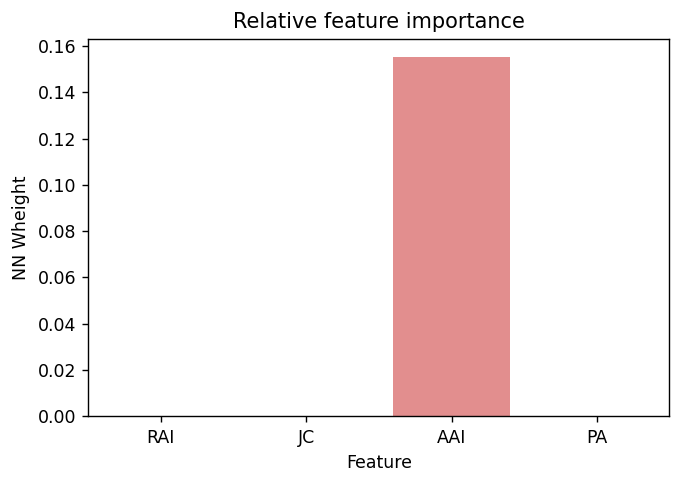

In [20]:
feature_importance(classification_model, feature_names, embed_dim=EMBED_DIM, attrs=ATTRS)

In [21]:
# testing the classifier

T = 0.5

x, _ = data_arrange(classifier_test, feature_names, train=False, attrs=ATTRS)

quality_probability = classification_model.predict(x).squeeze()
link_probability = link_prediction_model.predict(x).squeeze()

quality_label = [1 if i > T else 0 for i in quality_probability]

classifier_test = classifier_test.join(pd.Series(quality_probability, name='predicted_quality_prob'))
classifier_test = classifier_test.join(pd.Series(link_probability, name='predicted_link_probability'))
classifier_test = classifier_test.join(pd.Series(quality_label, name='predicted_quality_label'))

In [22]:
classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['predicted_link_probability']), axis=1)
test_median_error = classifier_test['true_abs_error'].median()
test_median_error

0.45935192704200745

In [23]:
classifier_test['true_quality_label'] = classifier_test.apply(lambda row: 1 if row['true_abs_error'] <= test_median_error else 0, axis=1)
classifier_test.head(5)

,node1,node2,goal,RAI,JC,AAI,PA,predicted_quality_prob,predicted_link_probability,predicted_quality_label,true_abs_error,true_quality_label
0,0,3617,1.0,0.0,0.0,0.0,0.000231,0.997244,0.459066,1,0.540934,0
1,1,3309,1.0,0.0,0.0,0.0,0.003922,0.000819,0.463649,0,0.536351,0
2,5,416,1.0,0.0,0.0,0.0,0.004845,0.000819,0.464796,0,0.535204,0
3,6,527,1.0,0.0,0.0,0.0,0.002077,0.000819,0.461357,0,0.538643,0
4,8,370,1.0,0.0,0.0,0.0,0.000692,0.235552,0.459638,0,0.540362,0


In [24]:
classifier_test[['true_quality_label']].value_counts()

true_quality_label
1                     799739
0                     541912
dtype: int64

In [25]:
classifier_test[['predicted_quality_label']].value_counts()

predicted_quality_label
1                          799614
0                          542037
dtype: int64

In [26]:
from sklearn import metrics

classifier_test.dropna(inplace=True)
y_true, y_pred = classifier_test['true_quality_label'], classifier_test['predicted_quality_label']

scores_df = pd.DataFrame()
scores_df['Metric'] = pd.Series(['Sample length', 'Precision', 'Recall', 'F1 score'])

scores_df['Score'] = pd.Series([
    len(classifier_test),
    metrics.precision_score(y_true, y_pred),
    metrics.recall_score(y_true, y_pred),
    metrics.f1_score(y_true, y_pred)
])

scores_df

,Metric,Score
0,Sample length,1.341651e+06
1,Precision,9.998474e-01
2,Recall,9.996911e-01
3,F1 score,9.997693e-01


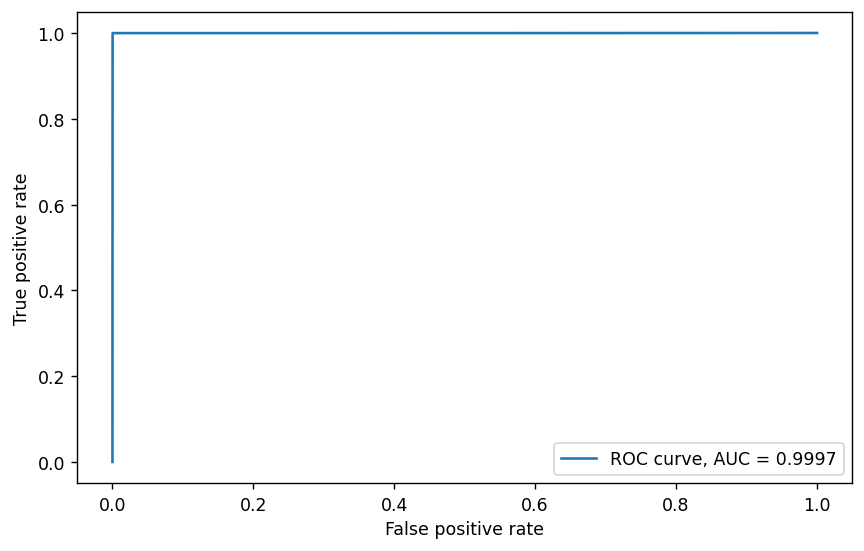

In [27]:
plot_auc(classifier_test, 'true_quality_label', 'predicted_quality_prob')